In [2]:
import pandas as pd
from heterogenity_clusters import get_trade_code_clusters
# Read data
df = pd.read_csv("pricing_treatment.csv", parse_dates=["date"])
trade_clusters = get_trade_code_clusters(df, n_clusters=3)
# Merge in cluster mapping (assuming you have trade_clusters dict from before)
df["cluster"] = df["trade_code"].map(trade_clusters)

# Define cut-off
cutoff = df["date"].max() - pd.Timedelta(days=60)
df["post"] = (df["date"] >= cutoff).astype(int)

# Average price by cluster and pre/post
price_change = (
    df.groupby(["cluster", "post"])["price"]
      .mean()
      .unstack()       # columns: 0 = before, 1 = after
      .rename(columns={0: "before", 1: "after"})
)

# Add a "difference" column
price_change["after_minus_before"] = price_change["after"] - price_change["before"]

print(price_change)


post          before        after  after_minus_before
cluster                                              
0        1997.885097  2104.154472          106.269375
1        4534.339888  4670.512568          136.172680
2        2999.955977  3159.696373          159.740396


In [ ]:
import numpy as np


trade_clusters = get_trade_code_clusters(df, n_clusters=3)
df["cluster"] = df["trade_code"].map(trade_clusters)

# === 2. Define pre/post cut-off ===
cutoff = df["date"].max() - pd.Timedelta(days=60)
df["post"] = (df["date"] >= cutoff).astype(int)

# Standardize treatment column to lowercase strings
df["treatment"] = df["treatment"].str.lower()

# === 3. Avg price by cluster × treatment × pre/post ===
price_change_tc = (
    df.groupby(["cluster", "treatment", "post"])["price"]
      .mean()
      .unstack()   # columns: 0 = before, 1 = after
      .rename(columns={0: "before", 1: "after"})
)
price_change_tc["after_minus_before"] = (
    price_change_tc["after"] - price_change_tc["before"]
)

print("=== Average price before & after by cluster and treatment ===")
print(price_change_tc.round(2))

# === 4. Optional: Compute within-cluster DiD for price ===
# DiD = (after - before) for treated − (after - before) for control
did_results = []
for cluster_id, sub in price_change_tc.groupby(level=0):
    try:
        delta_treat = sub.loc[(cluster_id, "treatment"), "after_minus_before"]
        delta_ctrl = sub.loc[(cluster_id, "control"), "after_minus_before"]
        did = delta_treat - delta_ctrl
    except KeyError:
        delta_treat = np.nan
        delta_ctrl = np.nan
        did = np.nan
    did_results.append({
        "cluster": cluster_id,
        "treated_change": delta_treat,
        "control_change": delta_ctrl,
        "price_DiD": did
    })

did_df = pd.DataFrame(did_results).set_index("cluster")
print("\n=== Price Difference-in-Differences within each cluster ===")
print(did_df.round(2))


=== Average price before & after by cluster and treatment ===
post                before    after  after_minus_before
cluster treatment                                      
0       control    2005.93  1998.33               -7.60
        treatment  1989.84  2209.98              220.14
1       control    4492.14  4406.46              -85.68
        treatment  4576.54  4934.56              358.03
2       control    2994.59  2992.15               -2.43
        treatment  3005.32  3327.24              321.91

=== Price Difference-in-Differences within each cluster ===
         treated_change  control_change  price_DiD
cluster                                           
0                220.14           -7.60     227.73
1                358.03          -85.68     443.71
2                321.91           -2.43     324.35


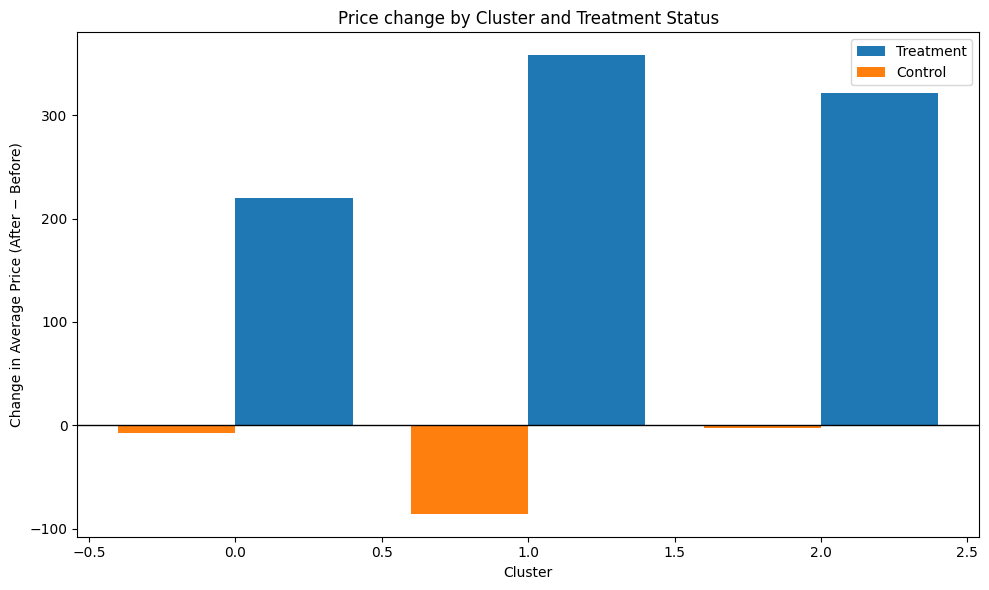

In [6]:
import matplotlib.pyplot as plt

# Reset index so cluster and treatment become columns for plotting
plot_df = price_change_tc.reset_index()

plt.figure(figsize=(10,6))
for status, color in zip(["treatment", "control"], ["#1f77b4", "#ff7f0e"]):
    subset = plot_df[plot_df["treatment"] == status]
    plt.bar(
        subset["cluster"] + (0.2 if status=="treatment" else -0.2),  # side-by-side
        subset["after_minus_before"],
        width=0.4,
        label=status.capitalize(),
        color=color
    )

plt.axhline(0, color="black", linewidth=1)
plt.ylabel("Change in Average Price (After − Before)")
plt.xlabel("Cluster")
plt.title("Price change by Cluster and Treatment Status")
plt.legend()
plt.tight_layout()
plt.show()
